In [1]:
import pandas as pd
import requests
import re
import time
from bs4 import BeautifulSoup
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def fetch(url):
    """
    Use BeautifulSoup to get the text of a web page.
    """
    r = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", r.text), "html.parser")
    return soup

Steps:
- Go to Sports-Reference's conference tournament page to get the conference acronyms (for url)
- For each season, go and get BPM of each player for all 32 conferences

In [4]:
# Get acronyms for all 32 conferences
conf_tourney_url = 'https://www.sports-reference.com/cbb/seasons/2019-conference-tournaments.html'
conf_tourney_soup = fetch(conf_tourney_url)
conf_tourney_table = conf_tourney_soup.find_all('table', {'id': 'conference-tournaments'})[0]
conf_dict = {}
for row in conf_tourney_table.find_all('th', {'data-stat': 'conf_name'}):
    if row.a:
        url = row.a['href']
        conf_name = url.replace('/cbb/conferences/', '')\
                       .replace('/2019.html#all_conference-tournament', '')
        conf_dict[conf_name] = row.text
        
conf_acronyms = list(conf_dict.keys())

In [5]:
def get_season_cbb_bpm(year, conf_acronyms=conf_acronyms):
    print(f'CBB Season {year} Scraping...')
    
    spr_url = 'https://www.sports-reference.com'
    conf_dfs = []
    
    conf_acronyms_adj = conf_acronyms.copy()
    if year < 2014:
        conf_acronyms_adj.remove('aac')
        if year == 2011:
            conf_acronyms_adj.remove('pac-12')
            conf_acronyms_adj.append('pac-10')
    
    for conf in conf_acronyms_adj:
        conf_url = f'{spr_url}/cbb/conferences/{conf}/{year}-stats.html'
        conf_soup = fetch(conf_url)
        conf_table = conf_soup.find_all('table', {'id': 'conference-stats'})[0]
        
        data = []
        cols = ['player', 'class', 'pos', 'school_name', 'g', 'mp', 'bpm']
        for row in conf_table.find_all('tr'):
            if row.find_all('td', {'data-stat': 'player'}):
                row_data = [row.find_all('td', {'data-stat': col})[0].text
                            for col in cols]
                row_data.append(row.find_all('td', {'data-stat': 'player'})[0].a['href'])
                data.append(row_data)
        conf_df = pd.DataFrame(data, columns=cols + ['spr_url'])
        conf_df['conference'] = conf
        
        conf_dfs.append(conf_df)
    
    output = pd.concat(conf_dfs)
    output['season'] = year
    
    print(f'CBB Season {year} Completed.')
    print()
    
    return output

In [6]:
for year in range(2011, 2022):
    get_season_cbb_bpm(year).to_csv(f'cbb_year_bpm/{year}.csv', index=False)
    time.sleep(10)

CBB Season 2011 Scraping...
CBB Season 2011 Completed.

CBB Season 2012 Scraping...
CBB Season 2012 Completed.

CBB Season 2013 Scraping...
CBB Season 2013 Completed.

CBB Season 2014 Scraping...
CBB Season 2014 Completed.

CBB Season 2015 Scraping...
CBB Season 2015 Completed.

CBB Season 2016 Scraping...
CBB Season 2016 Completed.

CBB Season 2017 Scraping...
CBB Season 2017 Completed.

CBB Season 2018 Scraping...
CBB Season 2018 Completed.

CBB Season 2019 Scraping...
CBB Season 2019 Completed.

CBB Season 2020 Scraping...
CBB Season 2020 Completed.

CBB Season 2021 Scraping...
CBB Season 2021 Completed.



## EDA

In [5]:
raw_df = pd.concat([pd.read_csv(f'cbb_year_bpm/{year}.csv')
                    for year in range(2011, 2022)])
Counter(raw_df['season'])

Counter({2011: 4418,
         2012: 4491,
         2013: 4564,
         2014: 4766,
         2015: 4746,
         2016: 4778,
         2017: 4803,
         2018: 4741,
         2019: 4768,
         2020: 4827,
         2021: 5020})

In [6]:
raw_df['mpg'] = raw_df['mp'] / raw_df['g']
cbb_df = raw_df[((raw_df['mpg'] >= 10) | (raw_df['mp'] >= 200)) & 
                (raw_df['g'] >= 10) & (~raw_df['bpm'].isna())]
Counter(cbb_df['season'])

Counter({2011: 3103,
         2012: 3118,
         2013: 3179,
         2014: 3280,
         2015: 3322,
         2016: 3312,
         2017: 3339,
         2018: 3306,
         2019: 3351,
         2020: 3290,
         2021: 3102})

In [7]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from IPython.core.pylabtools import figsize

In [8]:
sns.set()
matplotlib.rc('font', family='Heiti TC')

In [9]:
print(cbb_df['bpm'].median())

-0.7


Text(0.5, 0, 'BPM')

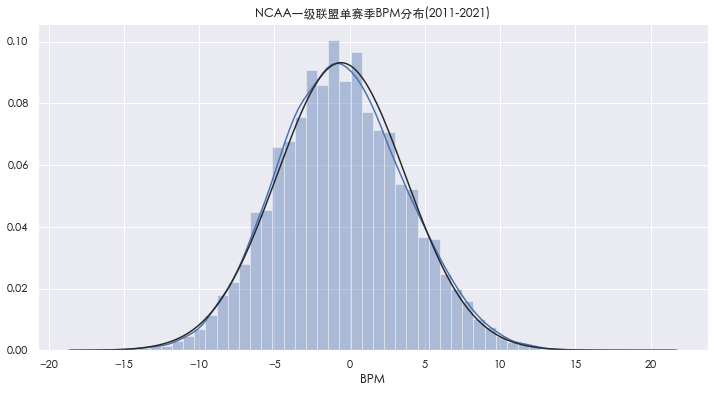

In [10]:
figsize(12, 6)
sns.distplot(cbb_df['bpm'], fit=norm)
plt.title('NCAA一级联盟单赛季BPM分布(2011-2021)')
plt.xlabel('BPM')

### Chinese Players

In [11]:
# Select players with draft year that is post-2015
cn_players = {'Michael Ou': '区俊炫', 'Michael Wang': '王泉泽', 'Kevin Zhang': '张镇麟', 
              'Benson Lin': '林庭谦', 'Ben Li': '李弘权', 'Johnny Wang': '王翊雄', 
              'Jeffrey Yan': '颜宇锋', 'Grant Sun': '孙鹤峰', 'Hefeng Sun': '孙鹤峰',
              'Tao Xu': '徐韬', 'Chris Tang': '唐子豪', 'Adili Kuerban': '阿迪力-库尔班',
              'Louis Tang': '唐维杰', 'Oscar Kao': '高国豪', 'Lewis Wang': '王律翔', 
              'Ray Chen': '陈盈骏', 'Alex Zhao': 'Qianjun Zhao', 'Siyao Sun': '孙思尧',
              'Ted Wang': '王泽铭', 'Jeff Wu': '吴永盛'}

In [75]:
cols = ['player', 'class', 'season', 'school_name', 'conference', 'g', 'mp', 'mpg', 'bpm']
temp = cbb_df[cbb_df['player'].isin(cn_players)][cols]
temp = temp.rename(columns={'player': '球员', 'class': '年级',
                            'school_name': '学校', 'g': '上场次数',
                            'mp': '上场时间', 'bpm': 'BPM', 
                            'conference': '赛区', 'season': '赛季',
                            'mpg': '场均上场时间'})
temp['上场时间'] = temp['上场时间'].apply(int)
temp['场均上场时间'] = temp['场均上场时间'].apply(lambda x: f'{x:.1f}')
temp['球员'] = temp['球员'].map(cn_players)
temp['赛区'] = temp['赛区'].map(conf_dict)
temp['年级'] = temp['年级'].map({'FR': '大一', 'SO': '大二', 'JR': '大三', 'SR': '大四'})
temp.sort_values('BPM', ascending=False)

球员  年级    赛季                           学校  \
2251      王泉泽  大一  2019                 Pennsylvania   
3081      林庭谦  大一  2020                       Bryant   
161       张镇麟  大二  2020                       Tulane   
3658      李弘权  大一  2021                       Lehigh   
157       张镇麟  大一  2019                       Tulane   
1832      王翊雄  大四  2021          Cal State Fullerton   
1188      吴永盛  大三  2018             Sacramento State   
1179      吴永盛  大一  2016             Sacramento State   
1678      王翊雄  大三  2020          Cal State Fullerton   
1681      王翊雄  大二  2019          Cal State Fullerton   
1226      陈盈骏  大四  2017                      Liberty   
3952      唐维杰  大一  2020  Virginia Military Institute   
1651      区俊炫  大二  2020         Cal State Northridge   
1646      区俊炫  大一  2019         Cal State Northridge   
4561       徐韬  大一  2013                San Francisco   
3846      王泽铭  大二  2012     Texas A&M-Corpus Christi   
753   阿迪力-库尔班  大二  2020               Kennesaw State   
3228      高国豪  大三  2020     Southeast Missouri State   
1206      吴永盛  大二  2017             Sacramento State   

                                赛区  上场次数  上场时间 场均上场时间   BPM  
2251                    Ivy League    26   471   18.1   1.3  
3081          Northeast Conference    32   752   23.5  -2.5  
161   American Athletic Conference    30   576   19.2  -2.7  
3658                Patriot League    14   170   12.1  -2.8  
157   American Athletic Conference    30   674   22.5  -3.2  
1832           Big West Conference    14   182   13.0  -3.2  
1188            Big Sky Conference    25   594   23.8  -3.5  
1179            Big Sky Conference    31   530   17.1  -3.7  
1678           Big West Conference    27   396   14.7  -4.0  
1681           Big West Conference    34   500   14.7  -4.6  
1226          Big South Conference    35   248    7.1  -4.9  
3952           Southern Conference    33   446   13.5  -5.7  
1651           Big West Conference    21   204    9.7  -6.4  
1646           Big West Conference    29   469   16.2  -6.5  
4561         West Coast Conference    27   376   13.9  -6.8  
3846          Southland Conference    24   226    9.4  -7.0  
753        Atlantic Sun Conference    27   512   19.0  -7.8  
3228        Ohio Valley Conference    22   297   13.5  -9.3  
1206            Big Sky Conference    13   158   12.2 -10.9

In [72]:
cbb_df[cbb_df['player'].isin(cn_players)].sort_values('season', ascending=False)

player class pos                  school_name   g     mp   bpm  \
3658         Ben Li    FR   F                       Lehigh  14  170.0  -2.8   
1832    Johnny Wang    SR   F          Cal State Fullerton  14  182.0  -3.2   
161     Kevin Zhang    SO   G                       Tulane  30  576.0  -2.7   
3952     Louis Tang    FR   G  Virginia Military Institute  33  446.0  -5.7   
3228      Oscar Kao    JR   G     Southeast Missouri State  22  297.0  -9.3   
3081     Benson Lin    FR   G                       Bryant  32  752.0  -2.5   
1678    Johnny Wang    JR   F          Cal State Fullerton  27  396.0  -4.0   
1651     Michael Ou    SO   C         Cal State Northridge  21  204.0  -6.4   
753   Adili Kuerban    SO   G               Kennesaw State  27  512.0  -7.8   
2251   Michael Wang    FR   F                 Pennsylvania  26  471.0   1.3   
1681    Johnny Wang    SO   F          Cal State Fullerton  34  500.0  -4.6   
1646     Michael Ou    FR   C         Cal State Northridge  29  469.0  -6.5   
157     Kevin Zhang    FR   G                       Tulane  30  674.0  -3.2   
1188        Jeff Wu    JR   G             Sacramento State  25  594.0  -3.5   
1226       Ray Chen    SR   G                      Liberty  35  248.0  -4.9   
1206        Jeff Wu    SO   G             Sacramento State  13  158.0 -10.9   
1179        Jeff Wu    FR   G             Sacramento State  31  530.0  -3.7   
4561         Tao Xu    FR   C                San Francisco  27  376.0  -6.8   
3846       Ted Wang    SO   C     Texas A&M-Corpus Christi  24  226.0  -7.0   

                                spr_url    conference  season        mpg  
3658         /cbb/players/ben-li-2.html       patriot    2021  12.142857  
1832    /cbb/players/johnny-wang-1.html      big-west    2021  13.000000  
161     /cbb/players/kevin-zhang-1.html           aac    2020  19.200000  
3952     /cbb/players/louis-tang-1.html      southern    2020  13.515152  
3228      /cbb/players/oscar-kao-1.html           ovc    2020  13.500000  
3081     /cbb/players/benson-lin-1.html     northeast    2020  23.500000  
1678    /cbb/players/johnny-wang-1.html      big-west    2020  14.666667  
1651     /cbb/players/michael-ou-1.html      big-west    2020   9.714286  
753   /cbb/players/adili-kuerban-1.html  atlantic-sun    2020  18.962963  
2251   /cbb/players/michael-wang-1.html           ivy    2019  18.115385  
1681    /cbb/players/johnny-wang-1.html      big-west    2019  14.705882  
1646     /cbb/players/michael-ou-1.html      big-west    2019  16.172414  
157     /cbb/players/kevin-zhang-1.html           aac    2019  22.466667  
1188        /cbb/players/jeff-wu-1.html       big-sky    2018  23.760000  
1226       /cbb/players/ray-chen-1.html     big-south    2017   7.085714  
1206        /cbb/players/jeff-wu-1.html       big-sky    2017  12.153846  
1179        /cbb/players/jeff-wu-1.html       big-sky    2016  17.096774  
4561         /cbb/players/tao-xu-1.html           wcc    2013  13.925926  
3846       /cbb/players/ted-wang-1.html     southland    2012   9.416667

### Japanese/Korean Players

In [13]:
# Select players with draft year that is post-2015
jk_players_p15 = {'Yuta Watanabe': '渡边雄太', 'Rui Hachimura': '八村垒', 'Kai Toews': '提布斯-海',
                  'Eito Yuminami': '弓波英人', 'Hyu Watanabe': '渡边飞勇', 'Avi Schafer': '舍费尔-幸树',
                  'Hyunjung Lee': '李贤政'}

In [14]:
cbb_df[cbb_df['player'].isin(jk_players_p15)].sort_values('season', ascending=False)

player class pos                school_name   g      mp   bpm  \
643    Hyunjung Lee    SO   G                   Davidson  22   657.0   7.8   
607    Hyunjung Lee    FR   G                   Davidson  28   584.0   4.1   
1798      Kai Toews    SO   G  North Carolina-Wilmington  13   345.0 -10.2   
1803      Kai Toews    FR   G  North Carolina-Wilmington  33  1014.0  -4.9   
4675  Rui Hachimura    JR   F                    Gonzaga  37  1117.0   9.4   
664   Yuta Watanabe    SR   F          George Washington  33  1207.0   3.1   
4645  Rui Hachimura    SO   F                    Gonzaga  37   765.0   6.6   
655   Yuta Watanabe    JR   F          George Washington  28   982.0   3.3   
633   Yuta Watanabe    SO   F          George Washington  38  1051.0   3.2   
651   Yuta Watanabe    FR   F          George Washington  35   787.0   2.6   

                                spr_url   conference  season        mpg  
643    /cbb/players/hyunjung-lee-1.html  atlantic-10    2021  29.863636  
607    /cbb/players/hyunjung-lee-1.html  atlantic-10    2020  20.857143  
1798      /cbb/players/kai-toews-1.html     colonial    2020  26.538462  
1803      /cbb/players/kai-toews-1.html     colonial    2019  30.727273  
4675  /cbb/players/rui-hachimura-1.html          wcc    2019  30.189189  
664   /cbb/players/yuta-watanabe-1.html  atlantic-10    2018  36.575758  
4645  /cbb/players/rui-hachimura-1.html          wcc    2018  20.675676  
655   /cbb/players/yuta-watanabe-1.html  atlantic-10    2017  35.071429  
633   /cbb/players/yuta-watanabe-1.html  atlantic-10    2016  27.657895  
651   /cbb/players/yuta-watanabe-1.html  atlantic-10    2015  22.485714

## Visualization

In [15]:
def plot_player_bpm(player, conf, year, player_name_dict=cn_players, conf_dict=conf_dict):
    year_df = cbb_df[cbb_df['season'] == year]
    x = year_df['bpm'].values
    y = year_df['mpg'].values
    plt.scatter(x, y, alpha=0.1, label='NCAA一级联盟球员')

    conf_cond = year_df['conference'] == conf
    x_c = year_df[conf_cond]['bpm'].values
    y_c = year_df[conf_cond]['mpg'].values
    plt.scatter(x_c, y_c, alpha=0.8, label=f'{conf_dict[conf]}球员')

    player_cond = year_df['player'] == player
    x_p = year_df[player_cond]['bpm'].values
    y_p = year_df[player_cond]['mpg'].values
    plt.scatter(x_p, y_p, color='red', label=f'{player_name_dict[player]} ({player})')
    player_coord = (x_p[0], y_p[0])
    plt.annotate(player_name_dict[player], player_coord)
    
    draftee_df = pd.read_csv(f'nba_draft_year_bpm/{year}.csv') 
    draftees_url = draftee_df[(draftee_df['conference'] == conf) &
                              (draftee_df['player'] != player)].merge(year_df, on=['spr_url'],
                                                                      how='inner')['spr_url'].values
    
    if len(draftees_url) > 0:
        draftee_cond = year_df['spr_url'].isin(draftees_url)
        draftees = year_df[draftee_cond]['player'].values
        x_d = year_df[draftee_cond]['bpm'].values
        y_d = year_df[draftee_cond]['mpg'].values
        plt.scatter(x_d, y_d, color='blue', label=f'{year}年同赛区被选中的球员')
        for i in range(len(draftees)):
            plt.annotate(draftees[i], (x_d[i], y_d[i]))
    
    season = f'{year-1}-{str(year)[2:]}'
    plt.title(f'{season}赛季NCAA一级联盟球员BPM')
    
    plt.xlabel('BPM')
    plt.ylabel('场均上场时间')
    plt.xlim(-18,22)
    plt.vlines(0, 5, 40, linestyles='--', colors='black')
    plt.legend(loc=4)

### 王翊雄 | Cal State Fullerton | Big West

In [16]:
player = 'Johnny Wang'
conf = 'big-west'

#### 大四

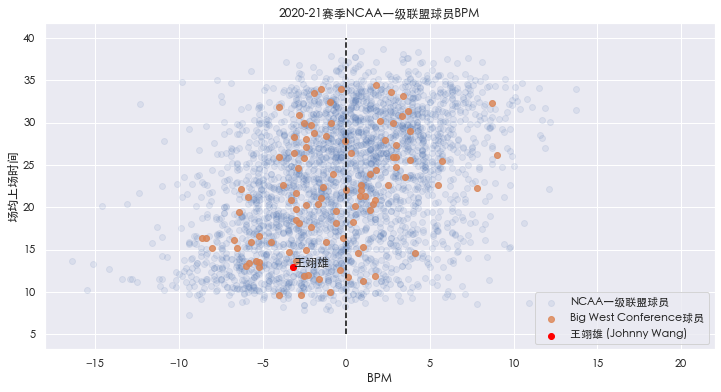

In [17]:
figsize(12, 6)
plot_player_bpm(player, conf, 2021)

#### 大三

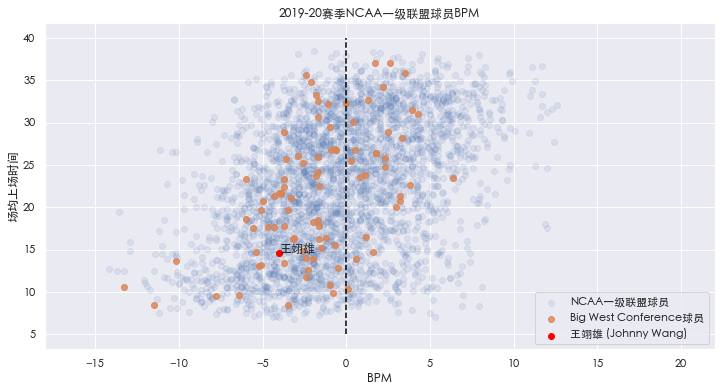

In [18]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

#### 大二

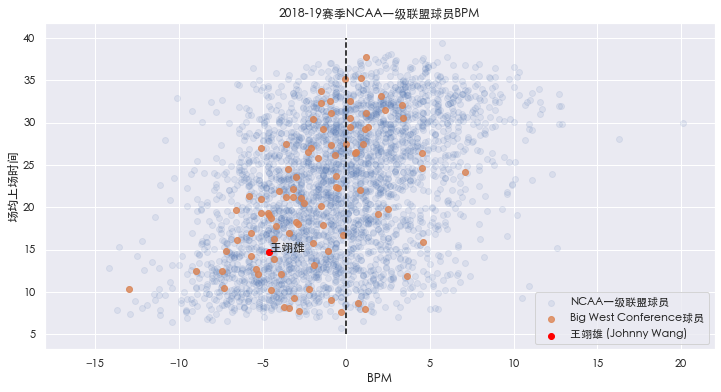

In [19]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019)

### 李弘权 | Lehigh | Patriot League

In [20]:
player = 'Ben Li'
conf = 'patriot'

#### 大一

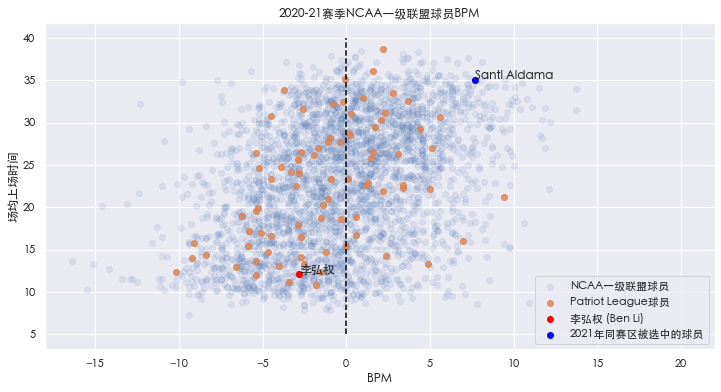

In [21]:
figsize(12, 6)
plot_player_bpm(player, conf, 2021)

### 张镇麟 | Tulane | AAC

In [22]:
player = 'Kevin Zhang'
conf = 'aac'

#### 大二

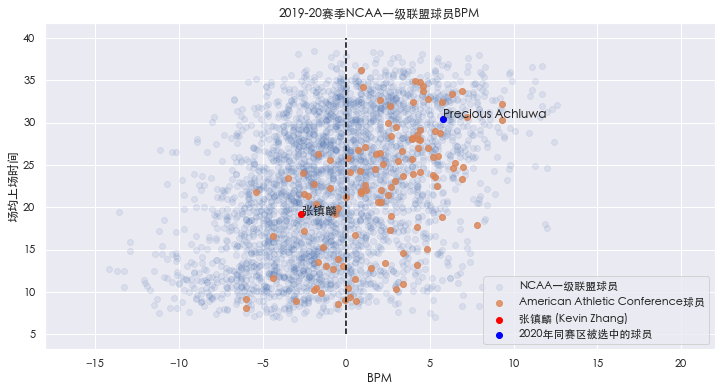

In [23]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

#### 大一

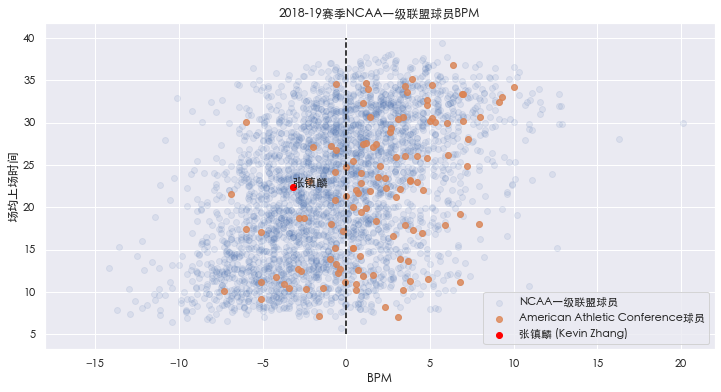

In [24]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019)

### 阿迪力-库尔班 | Kennesaw St | Atlantic Sun

In [25]:
player = 'Adili Kuerban'
conf = 'atlantic-sun'

#### 大二

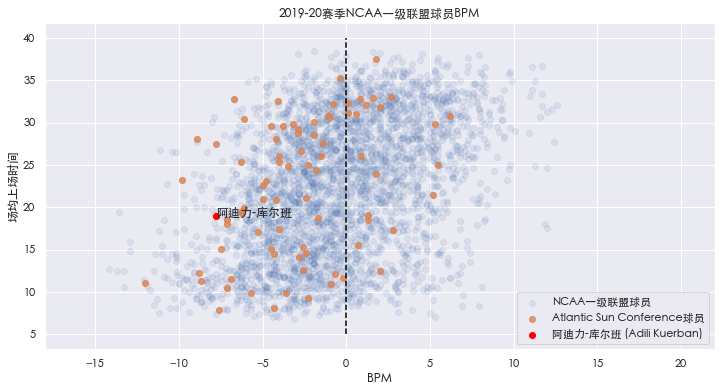

In [26]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

### 区俊炫 | Cal State Northridge | Big West

In [27]:
player = 'Michael Ou'
conf = 'big-west'

#### 大二

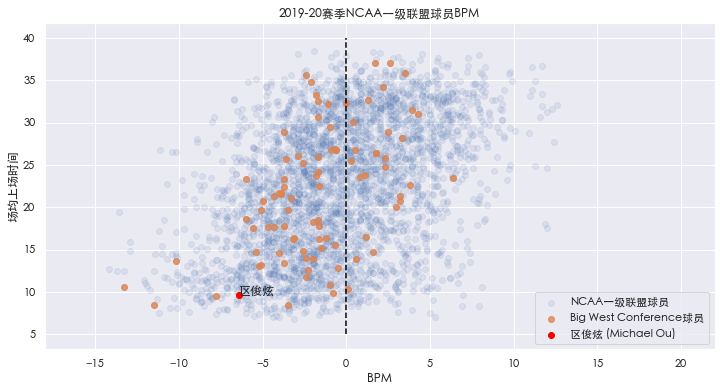

In [28]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

#### 大一

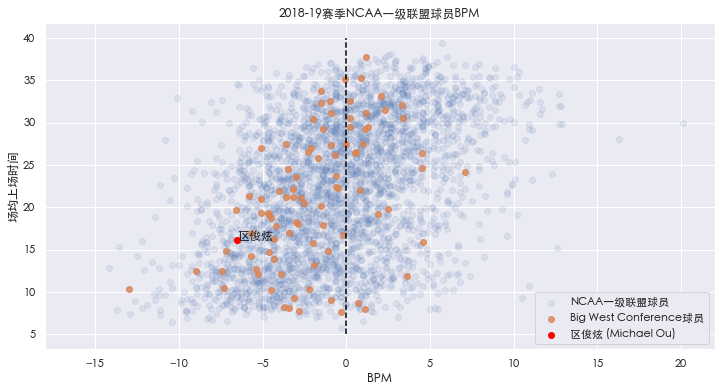

In [29]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019)

### 林庭谦 | Bryant | NEC

In [30]:
player = 'Benson Lin'
conf = 'northeast'

#### 大一

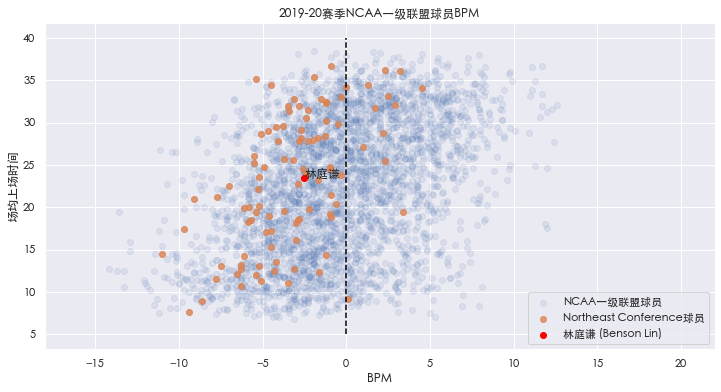

In [31]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

### 高国豪 | SE Missouri State | OVC

In [32]:
player = 'Oscar Kao'
conf = 'ovc'

#### 大三

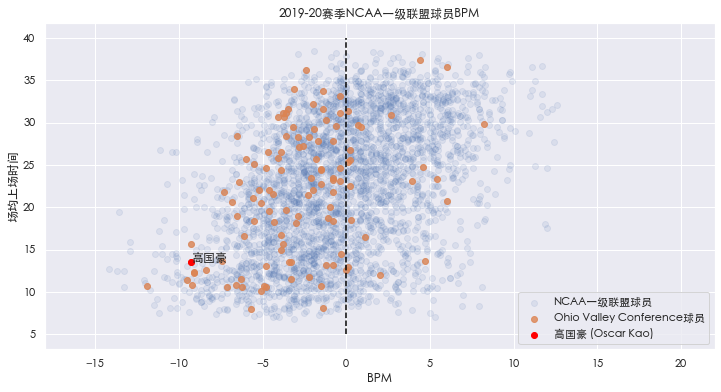

In [33]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

### 唐维杰 | VMI | SoCon

In [34]:
player = 'Louis Tang'
conf = 'southern'

大一

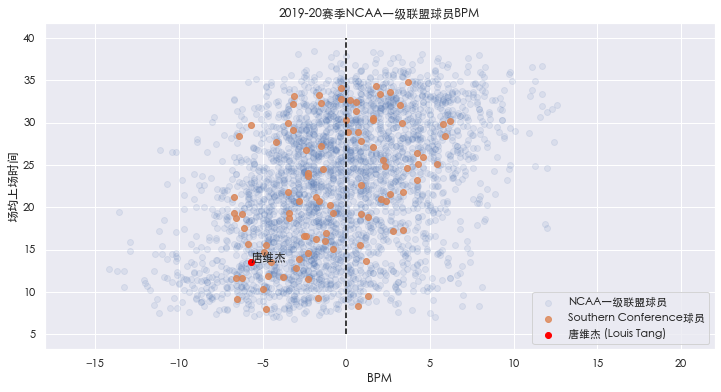

In [35]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020)

### 王泉泽 | Penn | SoCon

In [36]:
player = 'Michael Wang'
conf = 'ivy'

#### 大一

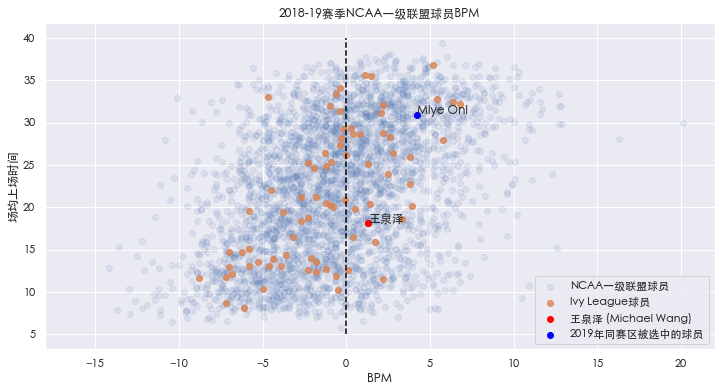

In [37]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019)

### 吴永盛 | Sacramento St | Big Sky

In [38]:
player = 'Jeff Wu'
conf = 'big-sky'

#### 大三

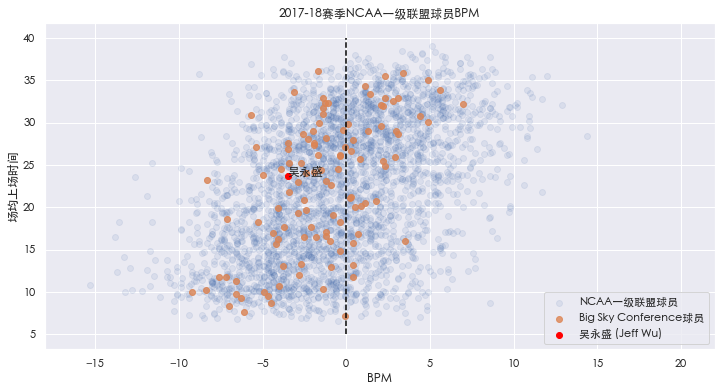

In [39]:
figsize(12, 6)
plot_player_bpm(player, conf, 2018)

#### 大二

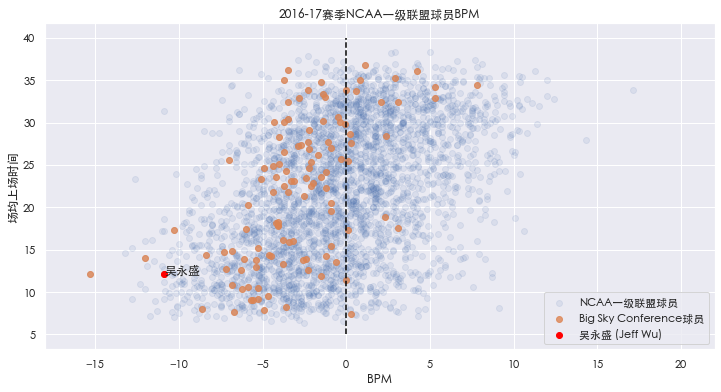

In [40]:
figsize(12, 6)
plot_player_bpm(player, conf, 2017)

#### 大一

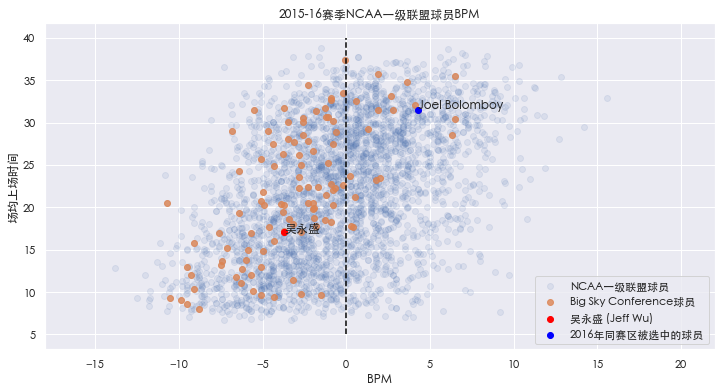

In [41]:
figsize(12, 6)
plot_player_bpm(player, conf, 2016)

### 陈盈骏 | Liberty | Big South

In [42]:
player = 'Ray Chen'
conf = 'big-south'

#### 大四

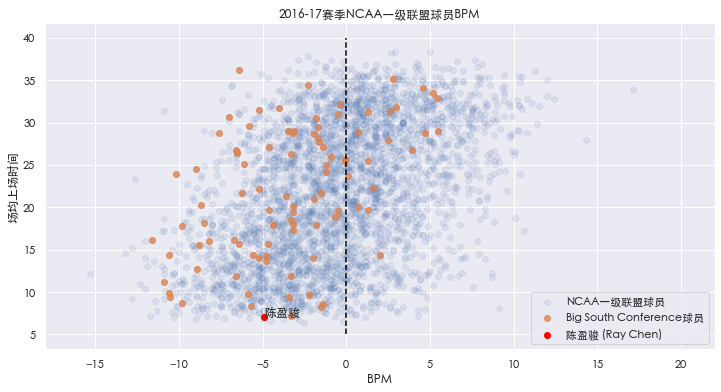

In [43]:
figsize(12, 6)
plot_player_bpm(player, conf, 2017)

### 徐韬 | San Francisco | WCC

In [44]:
player = 'Tao Xu'
conf = 'wcc'

#### 大一

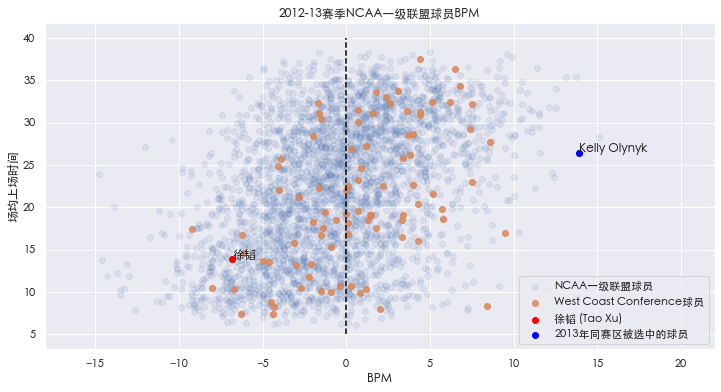

In [45]:
figsize(12, 6)
plot_player_bpm(player, conf, 2013)

### 王泽铭 | Texas A&M-Corpus Christi | Southland

In [46]:
player = 'Ted Wang'
conf = 'southland'

#### 大二

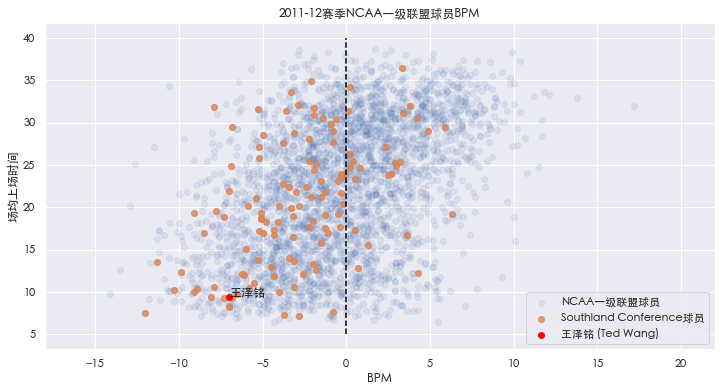

In [47]:
figsize(12, 6)
plot_player_bpm(player, conf, 2012)

### 李贤政 | Davidson | A-10

In [48]:
player = 'Hyunjung Lee'
conf = 'atlantic-10'

#### 大二

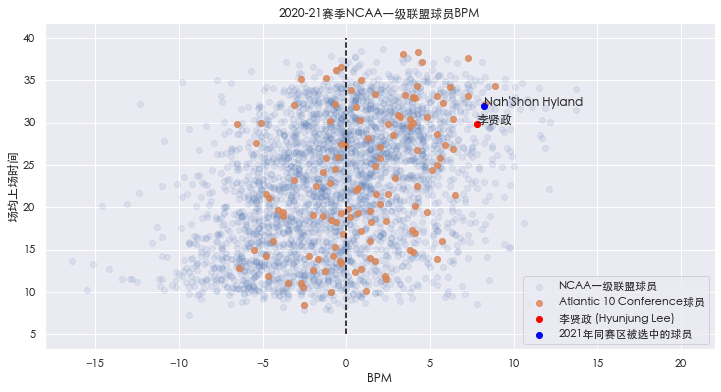

In [49]:
figsize(12, 6)
plot_player_bpm(player, conf, 2021, jk_players_p15)

#### 大一

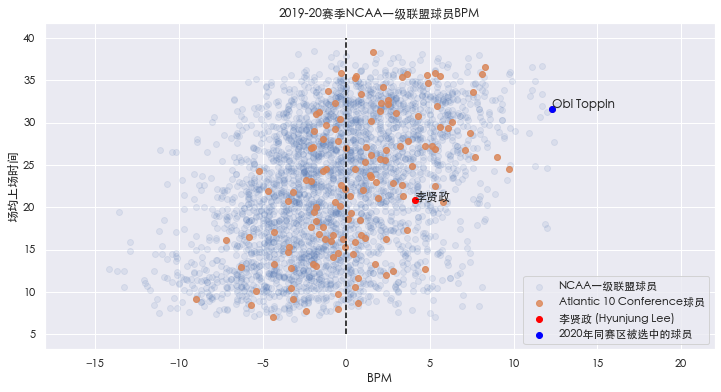

In [50]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020, jk_players_p15)

### 提布斯-海 | UNC Wilmington | CAA

In [83]:
player = 'Kai Toews'
conf = 'colonial'

#### 大二

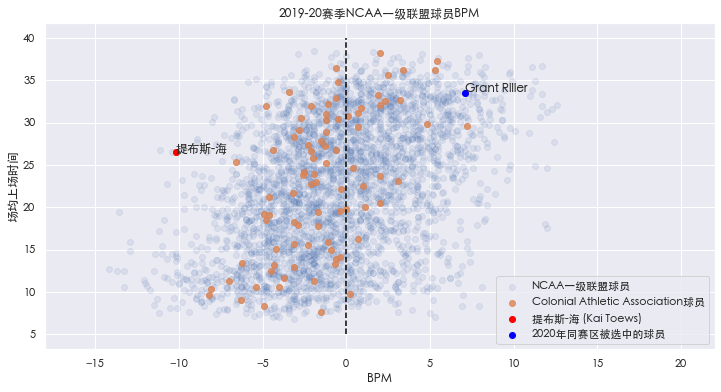

In [84]:
figsize(12, 6)
plot_player_bpm(player, conf, 2020, jk_players_p15)

#### 大一

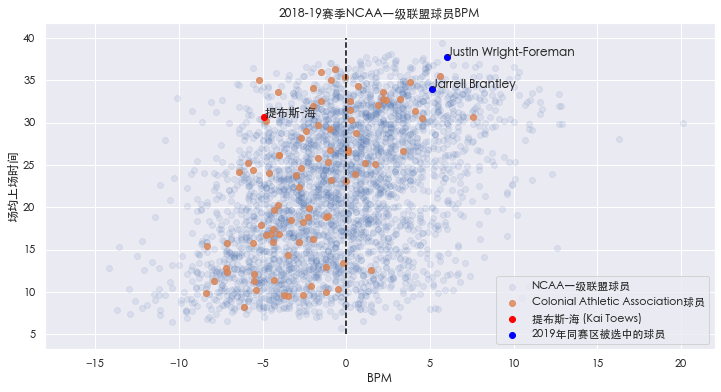

In [85]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019, jk_players_p15)

### 八村垒 | Gonzaga | WCC

In [54]:
player = 'Rui Hachimura'
conf = 'wcc'

#### 大三

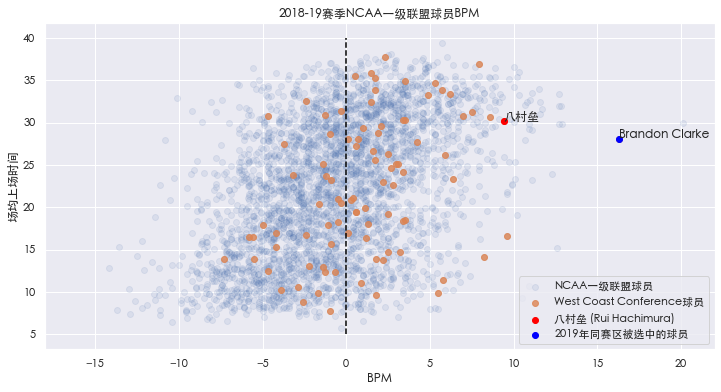

In [55]:
figsize(12, 6)
plot_player_bpm(player, conf, 2019, jk_players_p15)

#### 大二

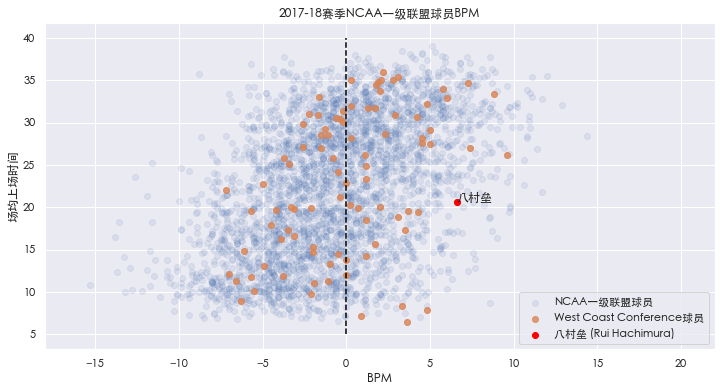

In [56]:
figsize(12, 6)
plot_player_bpm(player, conf, 2018, jk_players_p15)

### 渡边雄太 | George Washington | A-10

In [78]:
player = 'Yuta Watanabe'
conf = 'atlantic-10'

#### 大四

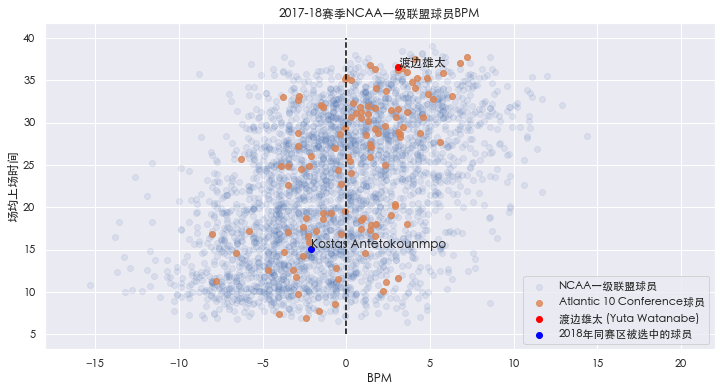

In [79]:
figsize(12, 6)
plot_player_bpm(player, conf, 2018, jk_players_p15)

#### 大三

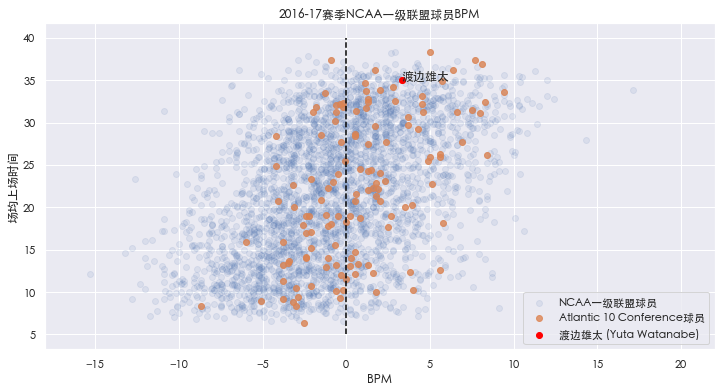

In [80]:
figsize(12, 6)
plot_player_bpm(player, conf, 2017, jk_players_p15)

#### 大二

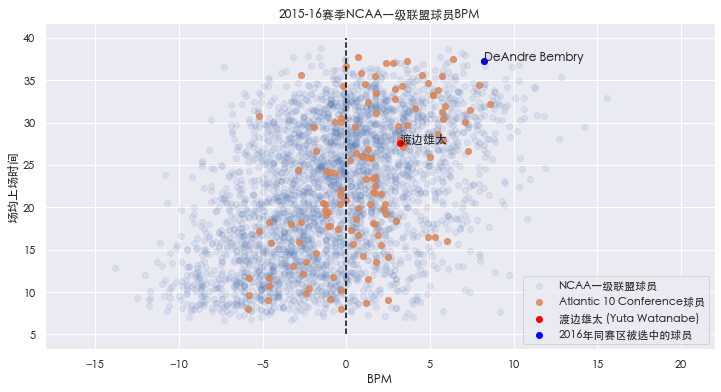

In [81]:
figsize(12, 6)
plot_player_bpm(player, conf, 2016, jk_players_p15)

#### 大一

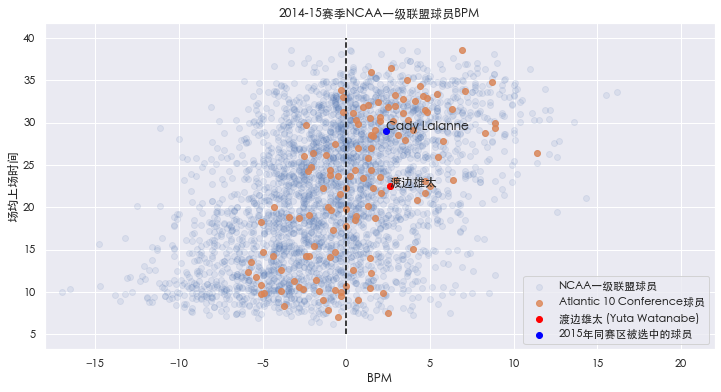

In [82]:
figsize(12, 6)
plot_player_bpm(player, conf, 2015, jk_players_p15)